In [1]:
import os
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
import time

import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm


In [2]:
# Functions 

def dist(lon1,lat1,lon2,lat2):

  lon1_rad = np.radians(lon1)
  lon2_rad = np.radians(lon2)
  lat1_rad = np.radians(lat1)
  lat2_rad = np.radians(lat2)
  #Assumes degrees input
  #Calculates in metres
  R = 6371000 #Radius of earth in metres (roughly)
  ## Uses Haversine formula
  a1 = (sin((lat2_rad-lat1_rad)/2))**2
  a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
  a = a1 + a2
  c = 2*atan2(sqrt(a),sqrt(1-a))
  d = R*c

  return d

def get_chord_lengths(ice_leads_msk,fb_height,seg_dist_x):
    floe_chord_lengths = np.zeros(len(ice_leads_msk)) # Making big enough array
    floe_fb = np.zeros(len(ice_leads_msk)) # Making big enough array
    ice_cnt_st = 0
    ice_cnt_en = 0
    floe_idx = 1
    for i in range(1,len(ice_leads_msk)):
        if (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 0): # start floe
            ice_cnt_st = i
            ice_cnt_en = i
        elif (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 1): # grow floe
            ice_cnt_en += 1
        elif (ice_leads_msk[i-1] == 1) and (ice_leads_msk[i] == 0): # stop floe
            floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
            floe_idx += 1
            
    # Removing spurious floes (< 10m, > 10 km, fb<0.1)
    remove_idx = np.where(floe_chord_lengths < 10)[0]  
    remove_idx = np.append(remove_idx,np.where(floe_chord_lengths > 10e3)[0])
    remove_idx = np.append(remove_idx,np.where(floe_fb < 0.1)[0])
    floe_fb = np.delete(floe_fb,remove_idx)
    floe_chord_lengths = np.delete(floe_chord_lengths,remove_idx)
    #
    return floe_chord_lengths, floe_fb

def get_lead_width_position(leads_msk,seg_dist_x):
    lead_width = np.zeros(len(leads_msk)) # Making big enough array
    lead_position = np.zeros(len(leads_msk)) # Making big enough array
    ice_cnt_st = 0
    ice_cnt_en = 0
    lead_idx = 1
    for i in range(1,len(leads_msk)):
        if (leads_msk[i] == 1) and (leads_msk[i-1] == 0): # start lead
            ice_cnt_st = i
            ice_cnt_en = i
        elif (leads_msk[i] == 1) and (leads_msk[i-1] == 1): # grow lead
            ice_cnt_en += 1
        elif (leads_msk[i-1] == 1) and (leads_msk[i] == 0): # stop lead
            lead_width[lead_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            lead_position[lead_idx] = (seg_dist_x[ice_cnt_en] + seg_dist_x[ice_cnt_st])/2
            lead_idx += 1
    #
    # Removing extra entries
    remove_idx = np.where(lead_width < 10)[0]  
    lead_position = np.delete(lead_position,remove_idx)
    lead_width = np.delete(lead_width,remove_idx)
    #
    return lead_width, lead_position

def get_lead_width_spacing_correlation(lead_widths,lead_positions,lead_width_bin_ranges):
    binned_lead_spacings = np.zeros(len(lead_width_bin_ranges)-1)
    binned_lead_count = np.zeros(len(lead_width_bin_ranges)-1)
    for i in range(len(lead_width_bin_ranges)-1):
        idx = np.where( (lead_widths >= lead_width_bin_ranges[i]) * (lead_widths < lead_width_bin_ranges[i+1]) )[0]
        spacings = np.abs(np.diff(lead_positions[idx]))
        if np.any(spacings):
            binned_lead_spacings[i] = np.mean(spacings)
            binned_lead_count[i] = len(idx) - 1 
    return binned_lead_count, binned_lead_spacings


In [3]:
# Testing out lead statistics
path = 'data/ATL10/Weddell/'
filelist = [file for file in os.listdir(path) if file.endswith('.h5')]

# Looping through h5 files in directory
cnt_file = 0
lead_month = []
lead_positions = []
lead_widths = []
subtrack_lengths = []

# Lead width bins
lead_width_bin_ranges = np.arange(10, 3000, 10)
lead_width_bin_means = 0.5*(lead_width_bin_ranges[0:-1] + lead_width_bin_ranges[1:])
nbins = len(lead_width_bin_means)
binned_lead_count = np.zeros(nbins)
binned_lead_spacings = np.zeros(nbins)

filelist = filelist
for fname in filelist:
# fname = filelist[15]
    this_ATL10=h5py.File(path+fname, 'r')
    print(fname)
    mth =  int(fname.split('_')[1][4:6])

    # Looping over beams. 
    # MG: CHANGE THIS TO ONLY INCLUDE STRONG BEAMS.
    for beam in ['gt1l','gt2l','gt3l','gt1r','gt2r','gt3r']:    # 
        # Getting data
        fb_height = np.array(np.squeeze(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/beam_fb_height'])) 
        fb_lat = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/latitude'])
        fb_lon = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/longitude'])
        height_segment_ssh_flag = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_ssh_flag'])
        seg_dist_x = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/seg_dist_x'])
        height_segment_type = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_type'])
        fb_height[fb_height > 30] = 0
        #
        beam_lead_n = this_ATL10[beam+'/freeboard_beam_segment/beam_lead_n']
        ref_height = this_ATL10[beam+'/freeboard_beam_segment/beam_refsurf_alongtrack_slope']
        ice_conc = this_ATL10[beam+'/freeboard_beam_segment/height_segments/ice_conc']
        lead_height = this_ATL10[beam+'/leads/lead_height']
        lead_length = this_ATL10[beam+'/leads/lead_length']
        lead_lat = this_ATL10[beam+'/leads/latitude']
        lead_lon = this_ATL10[beam+'/leads/longitude']
            
        # Creating binary array for: leads or spurious (0) / ice (1)
        height_segment_type = np.array(height_segment_type)
        leads_msk = 0*height_segment_type
        leads_msk[(height_segment_type <= 5)*(height_segment_type >= 2)] = 1

        # Splitting into sub-tracks
        subtrack_st_idx = np.array([], dtype='>i4')
        subtrack_en_idx = np.array([], dtype='>i4')
        seg_dx = np.abs(np.diff(seg_dist_x))
        seg_dx_thresh = 300
        seg_dx = np.insert(seg_dx,0,seg_dx_thresh+1)
        seg_dx = np.insert(seg_dx,len(seg_dx),seg_dx_thresh+1)
        for i in range(1,len(seg_dist_x)):
            if (seg_dx[i] < seg_dx_thresh) and (seg_dx[i-1] > seg_dx_thresh): # start subtrack
                subtrack_st_idx = np.append(subtrack_st_idx,i)
            # elif (seg_dx[i] < seg_dx_thresh) and (seg_dx[i-1] < seg_dx_thresh): # grow subtrack
            #     ice_cnt_en += 1
            elif (seg_dx[i-1] < seg_dx_thresh) and (seg_dx[i] > seg_dx_thresh): # stop subtrack
                subtrack_en_idx = np.append(subtrack_en_idx,i)

        if len(subtrack_st_idx) - len(subtrack_en_idx) == 1:
            subtrack_en_idx = np.append(subtrack_en_idx,len(seg_dist_x))
        
        # Removing subtracks that are too small
        subtrack_pts_min = len(seg_dist_x) / 15
        subtrack_pts  = subtrack_en_idx - subtrack_st_idx
        subtrack_validated_idx = [i for i in range(len(subtrack_pts)) if subtrack_pts[i] > subtrack_pts_min]
        subtrack_st_idx = subtrack_st_idx[subtrack_validated_idx].astype(int)
        subtrack_en_idx = subtrack_en_idx[subtrack_validated_idx].astype(int)

        for isub in range(len(subtrack_st_idx)):
            st = subtrack_st_idx[isub]
            en = subtrack_en_idx[isub]
            leads_msk_sub = leads_msk[st:en]
            seg_dist_x_sub = seg_dist_x[st:en]
            subtrack_lengths = np.append(subtrack_lengths,seg_dist_x_sub[-1]-seg_dist_x_sub[0])

            # Getting lead widths and positions
            lead_widths_sub, lead_positions_sub = get_lead_width_position(leads_msk_sub,seg_dist_x_sub)

            # Getting binned lead count and spacing 
            binned_lead_count_sub, binned_lead_spacings_sub = get_lead_width_spacing_correlation(lead_widths_sub,lead_positions_sub,lead_width_bin_ranges)

            # Adding to all subtracks
            binned_lead_count += binned_lead_count_sub
            binned_lead_spacings += binned_lead_count_sub*binned_lead_spacings_sub
            
with np.errstate(divide='ignore', invalid='ignore'):
    binned_lead_spacings = binned_lead_spacings / binned_lead_count

    # lead_month = np.append(lead_month,mth)


ATL10-02_20210203133757_06351001_005_01.h5
ATL10-02_20191208090337_11070501_005_02.h5
ATL10-02_20191025090101_04350501_005_02.h5
ATL10-02_20190301114641_09630201_005_02.h5
ATL10-02_20211030132017_05821301_005_01.h5
ATL10-02_20190317111321_12070201_005_02.h5
ATL10-02_20211014135334_03381301_005_01.h5
ATL10-02_20210303110522_10611001_005_01.h5
ATL10-02_20191031093538_05270501_005_02.h5
ATL10-02_20191005125113_01320501_005_02.h5
ATL10-02_20190905113210_10600401_005_02.h5
ATL10-02_20211103100324_06411301_005_01.h5
ATL10-02_20191002105936_00850501_005_02.h5
ATL10-02_20191104092718_05880501_005_02.h5
ATL10-02_20191013123433_02540501_005_02.h5
ATL10-02_20211203112222_11001301_005_01.h5
ATL10-02_20211021105400_04431301_005_01.h5
ATL10-02_20191030100118_05120501_005_02.h5
ATL10-02_20211119110427_08861301_005_01.h5
ATL10-02_20210208130358_07111001_005_01.h5
ATL10-02_20211020111939_04281301_005_01.h5
ATL10-02_20211108110341_07181301_005_01.h5
ATL10-02_20191010104255_02070501_005_02.h5
ATL10-02_20

In [4]:
print(subtrack_st_idx)
print(subtrack_en_idx)

[11661 39057 72127]
[37047 45734 92455]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


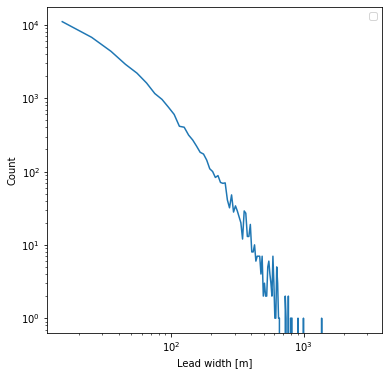

In [5]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1,1,1)
plt.plot(lead_width_bin_means,binned_lead_count)
plt.xlabel('Lead width [m]')
plt.ylabel('Count')
plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")

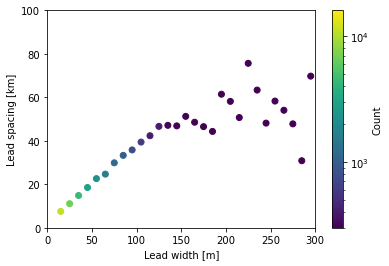

In [6]:
# Plotting lead statistics 
plt.scatter(lead_width_bin_means,binned_lead_spacings/1000, c = binned_lead_count, norm=colors.LogNorm(vmin=300, vmax=16000), cmap = 'viridis')
plt.xlabel('Lead width [m]')
plt.ylabel('Lead spacing [km]')
plt.xlim(0,300)
plt.ylim(0,100)
plt.colorbar(label='Count')
# plt.savefig('plots/lead_width_spacing_correlation.pdf')  

/var/folders/jv/28p3mxrj1w5f65d4m0dx67r40000gn/T/ipykernel_66699/296372086.py:4: RuntimeWarning: divide by zero encountered in true_divide
  s = 1 / c


(0.0, 300.0)

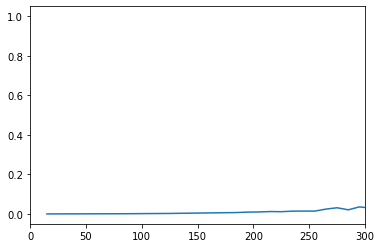

In [7]:
# plt.plot(lead_width_bin_means,binned_lead_count_agg[:,0],label='MJJA')
w = lead_width_bin_means
c = binned_lead_count
s = 1 / c

plt.plot(w,s)
plt.xlim(0,300)
# plt.ylim(0,0.01)

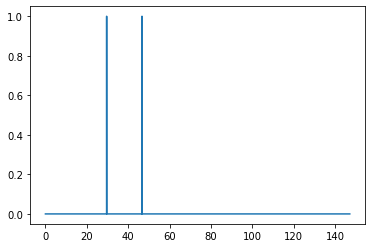

In [8]:
xx = (seg_dist_x_sub-seg_dist_x_sub[0])/1000

plt.plot(xx,leads_msk_sub)

In [9]:
np.max(subtrack_lengths/1000)

1437.6021772460342

In [10]:
seg_dist_x = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/seg_dist_x'])

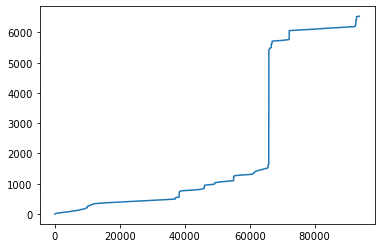

In [13]:
plt.plot((seg_dist_x-seg_dist_x[0])/1000)